In [51]:
"""This module prepares the data, splits into train/test, and performs undersampling to balance the data set. 
Then it trains and compares these machine learning models:
- Logistic Regression
- Ridge Classifier
- Random Forest Classifier
- K-Neighbours Classifier
-"""

import sqlite3
import pandas as pd

try:
    database_path = "data/data.db"
    conn = sqlite3.connect(database_path)
    query = open('data/fetch_all.sql', 'r').read()
    df_raw = pd.read_sql_query(query, conn)
except (sqlite3.Error, FileNotFoundError) as e:
    print(f"An error occurred: {e}")
finally:
    if 'conn' in locals():
        conn.close()

# Filter only rows with 'yes' or 'no' in the 'y' column\
df_raw.set_index('client_id', inplace=True)

df = df_raw[df_raw['y'].isin(['no', 'yes'])]

# Isolate the unseen data
df_pool = df_raw[df_raw['y'].isin(['yes', 'unknown'])]
df_pool.head()

# Drop specified columns
cols_to_drop = ['account_id', 'campaign_id', 'outcome_id', 'previous', 'poutcome', 'month']
df = df.drop(columns=cols_to_drop)
df_pool = df_pool.drop(columns=cols_to_drop)


In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

def preprocess_data(df):
    # Binning day of the week into Early, Mid, and Late
    bins = [0, 9, 19, 31]
    labels = ['early', 'mid', 'late']
    df['day_bin'] = pd.cut(df['day'], bins=bins, labels=labels, right=True)

    # Binning age into common bins
    age_bins = [0, 25, 36, 55, 65, 100]
    age_labels = ['<25', '25-35', '36-55', '55-65', '65+']
    df['age_bin'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

    # Identify numerical and categorical columns
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = ['job', 'marital', 'education', 'in_default', 'housing', 'loan', 'contact', 'day_bin', 'age_bin', 'y']

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_features = encoder.fit_transform(df[categorical_columns])

    # Create a DataFrame with the encoded features
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit and transform the numerical columns
    scaled_numeric_features = scaler.fit_transform(df[numerical_columns])

    # Create a DataFrame with the scaled numerical features
    scaled_numeric_df = pd.DataFrame(scaled_numeric_features, columns=numerical_columns)

    # Concatenate the scaled numerical features and the encoded categorical features
    df_enc = pd.concat([scaled_numeric_df, encoded_df], axis=1)

    return df_enc

df_enc = preprocess_data(df)
df_enc.columns
# print(df_enc.head())

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'in_default_yes',
       'housing_yes', 'loan_yes', 'contact_telephone', 'contact_unknown',
       'day_bin_late', 'day_bin_mid', 'age_bin_36-55', 'age_bin_55-65',
       'age_bin_65+', 'age_bin_<25', 'y_yes'],
      dtype='object')

In [53]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming df_encoded_min_max_scaled is the dataframe to be split
X = df_enc.drop(columns=['y_yes'])
y = df_enc['y_yes']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [54]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets with 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6400, 33)
X_test shape: (1600, 33)
y_train shape: (6400,)
y_test shape: (1600,)


In [55]:
# Filter X for rows where y is 1
X_y_1 = X[y == 1]

# Calculate summary statistics for X_y_1
stats_X_y_1 = X_y_1.describe().transpose()

# Calculate summary statistics for X_test
stats_X_test = X_test.describe().transpose()

# Display the statistics
print("Statistics for X where y = 1:")
print(stats_X_y_1)

print("\nStatistics for X_test:")
print(stats_X_test)

Statistics for X where y = 1:
                     count      mean       std       min       25%       50%  \
age                  521.0  0.124942  1.240257 -2.096455 -0.867145 -0.110647   
balance              521.0  0.049612  0.812280 -0.873510 -0.415929 -0.236818   
day                  521.0 -0.031156  0.998593 -1.808625 -0.838546 -0.110987   
duration             521.0  1.111434  1.502248 -0.900447 -0.015246  0.685218   
campaign             521.0 -0.169430  0.672808 -0.576829 -0.576829 -0.255231   
pdays                521.0  0.288408  1.218290 -0.407218 -0.407218 -0.407218   
job_blue-collar      521.0  0.132438  0.339292  0.000000  0.000000  0.000000   
job_entrepreneur     521.0  0.028791  0.167379  0.000000  0.000000  0.000000   
job_housemaid        521.0  0.026871  0.161863  0.000000  0.000000  0.000000   
job_management       521.0  0.251440  0.434258  0.000000  0.000000  0.000000   
job_retired          521.0  0.103647  0.305095  0.000000  0.000000  0.000000   
job_self-e

Model: Logistic Regression
Best Parameters: {'C': 0.1, 'solver': 'liblinear'}
Cross-Validation Score: 0.8112499999999999
Test Accuracy: 0.8
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80       803
         1.0       0.80      0.80      0.80       797

    accuracy                           0.80      1600
   macro avg       0.80      0.80      0.80      1600
weighted avg       0.80      0.80      0.80      1600



Model: Ridge Classifier
Best Parameters: N/A (RidgeClassifierCV performs internal CV)
Cross-Validation Score: 0.80421875
Test Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79       803
         1.0       0.79      0.79      0.79       797

    accuracy                           0.79      1600
   macro avg       0.79      0.79      0.79      1600
weighted avg       0.79      0.79      0.79      1600



Model: Random F

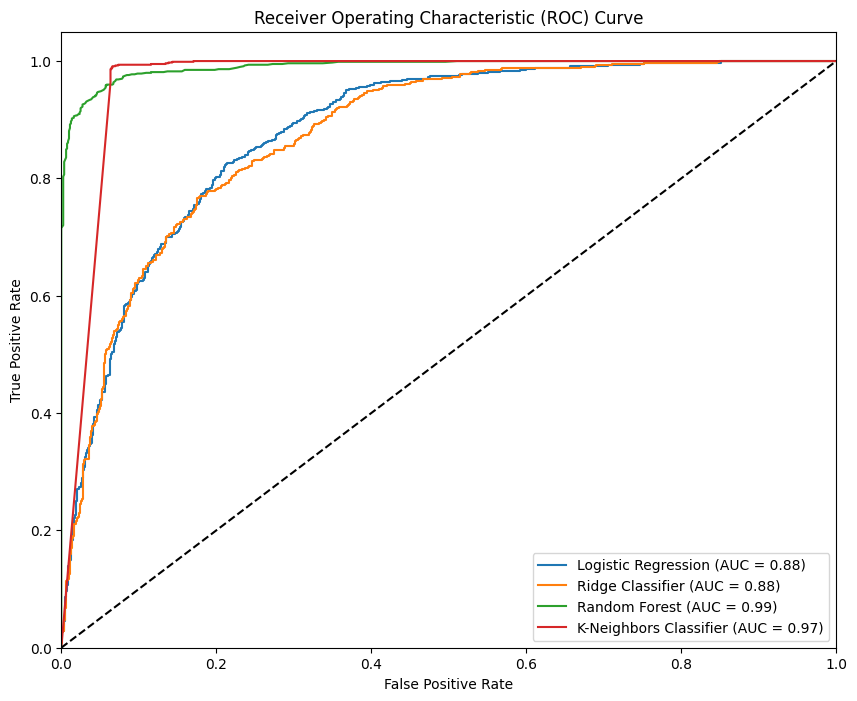

In [56]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold


# Define the models and their hyperparameters
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear']
        }
    },
    'Ridge Classifier': {
        'model': RidgeClassifierCV(alphas=[0.1, 1.0, 10.0], cv=5),
        'params': {}
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'K-Neighbors Classifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    }
}

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and hyperparameter tuning
results = []
roc_data = {}
for model_name, model_info in models.items():
    if model_name == 'Ridge Classifier':
        clf = model_info['model']
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.decision_function(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        roc_data[model_name] = (y_test, y_pred_proba)
        results.append({
            'Model': model_name,
            'Best Parameters': 'N/A (RidgeClassifierCV performs internal CV)',
            'Cross-Validation Score': clf.score(X_train, y_train),
            'Test Accuracy': accuracy,
            'Classification Report': classification_report(y_test, y_pred)
        })
    else:
        clf = GridSearchCV(model_info['model'], model_info['params'], cv=kf, scoring='accuracy')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        accuracy = accuracy_score(y_test, y_pred)
        roc_data[model_name] = (y_test, y_pred_proba)
        results.append({
            'Model': model_name,
            'Best Parameters': clf.best_params_,
            'Cross-Validation Score': clf.best_score_,
            'Test Accuracy': accuracy,
            'Classification Report': classification_report(y_test, y_pred)
        })

# Display the results
for result in results:
    print(f"Model: {result['Model']}")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Cross-Validation Score: {result['Cross-Validation Score']}")
    print(f"Test Accuracy: {result['Test Accuracy']}")
    print(f"Classification Report:\n{result['Classification Report']}")
    print("\n" + "="*80 + "\n")

# Plot ROC curves
plt.figure(figsize=(10, 8))
for model_name, (y_test, y_pred_proba) in roc_data.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [57]:
# Train the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=100, random_state=42)
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [67]:
data_cleaned = preprocess_data(df_pool)
data_cleaned.drop(columns=['y_yes'], inplace=True)
data_cleaned['Probability'] = best_rf_model.predict_proba(data_cleaned)[:, 1]


In [72]:
import csv

# Select the top 5,000 clients
selected_clients = data_cleaned.sort_values(by='Probability', ascending=False).head(5000)

selected_clients.index.name = 'target'

selected_clients.to_csv("second_phase_target_complete.csv", index=True)
selected_clients.index.to_series().to_csv("second_phase_target.csv", header=True, index=False)